In [1]:
import matplotlib.pyplot as plt
# from networkx import minimum_cut, DiGraph
from mip import *

from src.read_instance import MDOVRP

In [2]:
# filepath = "Instancias/ES-n78-m2-Q10138.txt"
filepath = "Instancias/ES-n78-m2-Q10138_with_depot.txt"
# filepath = "Instancias/Vrp-Set-A/A-n80-m2-Q60.vrp"

In [3]:
N, D, V, Q, q, c, vehicles_depot, coord_x, coord_y = MDOVRP(filepath)

Usando a formulação $MDOVRP_{2i− flv}$ de Lalla-Ruiz e Mes (2019)


    Lalla-Ruiz, Eduardo, and Martijn Mes. "Mathematical formulations and improvements for the multi-depot open vehicle routing problem." Optimization Letters 15 (2021): 271-286.

In [4]:
print(D)
print(vehicles_depot)

[76, 77]
[4, 4]


In [5]:
#cria o modelo
model = Model('PRVMD', solver_name = GUROBI)

# Variaveis de decisao
x = [[model.add_var(var_type=BINARY) if i!=j else model.add_var(lb=0, ub=0) for i in V] for j in V]
u = [[model.add_var(var_type=CONTINUOUS) if i!=j else model.add_var(lb=0, ub=0) for i in V] for j in V]
y = [model.add_var(var_type=BINARY) for i in N]
w = [model.add_var(var_type=BINARY) for i in N]

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID
Academic license - for non-commercial use only - registered to thiago.giachetto@aluno.ufop.edu.br


\begin{equation}
\label{eq:9}
    x_{ij} \in \{0, 1\}, \quad \forall i, j \in V
\end{equation}

\begin{equation}
\label{eq:10}
    u_{ij} \geq 0, \quad \forall i, j \in V
\end{equation}

\begin{equation}
\label{eq:10.1}
    w_{j} \in \{0, 1\}, \quad \forall j \in N
\end{equation}

In [6]:
# Funcao objetivo
alfa = 0.001

A = alfa
B = 1 - alfa

model.objective = minimize(A*xsum(x[i][j] * c[i,j] for i in V for j in V if i != j) - B*xsum(q[j]*w[j] for j in N))

In [7]:
def objective(alfa, c, q, x, w):
    A = alfa
    B = 1 - alfa
    
    return minimize(A*xsum(x[i][j] * c[i,j] for i in V for j in V if i != j) - B*xsum(q[j]*w[j] for j in N))

\begin{equation}
\label{eq:1}
 Minimizar \quad A\sum_{i \in V }\sum_{j \in V} c_{ij}x_{ij} - B\sum_{j \in N} q_{j}w_{j}
\end{equation}

In [8]:
# Restricao 3
for j in N:
    model += xsum(x[i][j] for i in V if i != j) == w[j]

\begin{equation}
    \sum_{i \in V, i \neq j}x_{ij} = w_{j}, \quad \forall j \in N
    \tag{2}
\end{equation}

In [9]:
# Restricao 7

for j in N:
    model += (xsum(x[i][j] for i in V if i != j) - xsum(x[j][i] for i in N if i != j)) >= 0

\begin{equation}
    \sum_{i \in V, i \neq j}x_{ij} - \sum_{i \in N, i \neq j}x_{ji} \geq 0, \quad \forall j \in N
    \tag {18}
\end{equation}

In [10]:
# Restricao 8
for i in V:
    for j in V:
        if i != j:
            model += x[i][j] + x[j][i] <= 1

\begin{equation}
    x_{ij} + x_{ji} \leq 1, \quad \forall i, j \in V, i \neq j
    \tag {19}
\end{equation}

In [11]:
# Restricao 9
# Ninguem volta para o depósito
model += xsum(x[j][k] for k in D for j in V) == 0

\begin{equation}
    \sum_{k \in D}\sum_{j \in V}x_{jk} = 0
    \tag {20}
\end{equation}

In [12]:
# Restricao 10 -> se cidade não é atendida, restrição é esquecida
for j in N:
    model += (xsum(u[i][j] for i in V if i != j) - xsum(u[j][i] for i in V if i != j) - q[j]) >= -Q*(1 - w[j])

\begin{equation}
    (\sum_{i \in V, i \neq j}u_{ij} - \sum_{i \in V, i \neq j}u_{ji}) - q_{j} \geq -Q(1 - w_{j}), \quad \forall j \in N
    \tag {21}
\end{equation}

    Wolsey, Laurence A. Integer programming (pp. 11). John Wiley & Sons, 2020.

In [13]:
# restrição 3 -> que liga x e w
for j in N:
    xsum(x[i][j] for i in V if i != j) == w[j]

\begin{equation}
    \sum_{i \in V, i \neq j}x_{ij} = w_{j}, \quad \forall j \in N
    \tag {21}
\end{equation}

In [14]:
#Restricao 11
for i in N:
    for j in N:
        model += (Q - q[i])*x[i][j] >= u[i][j]

\begin{equation}
    (Q - q_i) \cdot x_{ij} \geq u_{ij}, \quad \forall i, j \in N
    \tag {22}
\end{equation}

In [15]:
# Restricao 12
for k in D:
    for j in N:
        model += Q * x[k][j] >= u[k][j]

\begin{equation}
    Q \cdot x_{kj} \geq u_{kj}, \quad \forall k \in D, j \in N
    \tag {23}
\end{equation}

In [16]:
# # Restricao 13
# menor distancia de algum deposito ate a cidade
d = [min([c[j, i] for j in D]) for i in N]
# menor distancia entre cidade i e quaisquer outra cidade
r = [min([c[j, i] for j in N if i != j]) for i in N]
# máxima menor distancia entre duas cidades
M = max(r)

# d[i] >= r[i] <=> é mais longe ir de algum depósito do q de outra cidade => y in {0, 1}
# d[i] < r[i] <=> é mais perto sair de algum depósito do q de qualquer outra cidade => y = 1
for i in N:
    model += d[i] + M * y[i] >= r[i]*w[i]

\begin{equation}
    d_{i} + M y_{i} \geq r_{i}w_{i}, \quad \forall k \in N
    \tag {8}
\end{equation}

In [17]:
# Restricao 14

for i in N:
    k_l = D[np.argmin([c[j, i] for j in D], axis=0)]
    model += x[k_l][i] >= y[i]

\begin{equation}
    x_{k'i} \geq y_{i}, \quad \forall i \in N, k' = argmin(c_{ki})_{k \in D}
    \tag {9}
\end{equation}

In [18]:
# Restricao 4 - quantidade veiculos por deposito

for pos, k in enumerate(D):
    model += xsum(x[k][i] for i in N) <= vehicles_depot[pos]
# for lim_vehicle in vehicles_depot:
#     model += xsum(x[k][i] for k in D for i in N) <= lim_vehicle

In [19]:
# Restricao 5 -> na demanda relacionado ao limite de caminhões

model += xsum(q[j]*w[j] for j in N) <= sum(vehicles_depot)*Q

In [20]:
# Restricao 6 -> de distancia maxima entre duas cidades

for i in V:
    for j in V:
        if i != j:
            model += c[i,j]*x[i][j] <= 180

## All feasible found solutions

In [21]:
dist = lambda x, k: sum([(1 if x[i][j].xi(k)>0.98 else 0) * c[i,j] for i in V for j in V if i != j])
demanda = lambda w, k: sum((q[j] if w[j].xi(k)>0.98 else 0) for j in N)


for k in range(model.num_solutions):
    print(f"{k}: dist: {dist(x, k)} dem: {demanda(w, k)}")

In [22]:
model.sol_pool_size

10

In [24]:
import numpy as np

steps = 30
solutions_obj = set()

for alfa in np.linspace(0, 1, steps, endpoint=True):
    model.objective = objective(alfa, c, q, x, w)
    num_solutions = 0
    
    for i in range(5):
        model.threads = 2
        status = model.optimize(max_seconds=60)
#         status = OptimizationStatus.FEASIBLE
    
        if status in (OptimizationStatus.INFEASIBLE, OptimizationStatus.ERROR):
            break
            
        if model.num_solutions > num_solutions:
            num_solutions = model.num_solutions
            
            for k in range(model.num_solutions):
                obj_calc = (dist(x,k), demanda(w, k))
                
#                 if obj_calc is not in solutions_obj:
                solutions_obj.add(obj_calc)
                    
        
        if status == OptimizationStatus.OPTIMAL:
            break
        
        print(f"number of solutions: {len(solutions_obj)}")

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 2 threads
Academic license - for non-commercial use only - registered to thiago.giachetto@aluno.ufop.edu.br
Optimize a model with 18324 rows, 12320 columns and 59808 nonzeros
Model fingerprint: 0xf8963e61
Variable types: 6162 continuous, 6158 integer (6158 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [3e+02, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+04]

MIP start from previous solve produced solution with objective -80097 (0.01s)
Loaded MIP start from previous solve with objective -80097

Presolve removed 13870 rows and 6497 columns
Presolve time: 0.14s
Presolved: 4454 rows, 5823 columns, 21752 nonzeros
Variable types: 2832 continuous, 2991 integer (2991 binary)

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.02s

Barrier stati

 15792 14297 -80337.000  161   89 -80097.000 -81104.000  1.26%   160  182s
 16691 14619 -80337.000  584  100 -80097.000 -81104.000  1.26%   159  185s
 17323 15271 -81102.659   72   28 -80097.000 -81104.000  1.26%   157  190s
 17998 15634 -81104.000   67   46 -80097.000 -81104.000  1.26%   156  196s
 18348 16202 -80831.000  209   39 -80097.000 -81104.000  1.26%   156  201s
 19274 16843 -81104.000   52   38 -80097.000 -81104.000  1.26%   155  205s
 19947 17445 -81104.000   50   49 -80097.000 -81104.000  1.26%   156  210s
 20478 17881 -81104.000   64   28 -80097.000 -81104.000  1.26%   159  215s
 21790 19385 -80742.000   70   33 -80097.000 -81104.000  1.26%   159  220s
 22797 20203 -80750.000  152   29 -80097.000 -81104.000  1.26%   158  226s
 23502 20659 -80750.000  185   33 -80097.000 -81104.000  1.26%   158  230s
 24454 21550 -80723.000  261   40 -80097.000 -81104.000  1.26%   157  236s
 25008 21870 -80478.000  153   34 -80097.000 -81104.000  1.26%   158  240s

Cutting planes:
  Lift-a

   928   857 -78233.967   28  147 -77083.991 -78233.978  1.49%  92.0   40s
H  951   833                    -77085.36479 -78233.964  1.49%  95.3   42s
H  955   790                    -77085.86341 -78233.964  1.49%  95.4   42s
H  956   753                    -77085.92197 -78233.964  1.49%  95.6   44s
   958   793 -78232.380   35  134 -77085.922 -78233.964  1.49%  95.6   46s
H  999   793                    -77088.96762 -78233.964  1.49%   100   49s
  1050   886 -78232.582   59  130 -77088.968 -78233.962  1.49%   103   53s
  1177   960 -78233.768   41  127 -77088.968 -78233.883  1.49%   110   58s
  1294   967 -78233.568   67  147 -77088.968 -78233.883  1.49%   121   60s

Cutting planes:
  Gomory: 21
  Lift-and-project: 1
  Cover: 1
  Implied bound: 20
  Clique: 7
  MIR: 60
  StrongCG: 1
  Flow cover: 39
  Zero half: 1
  RLT: 5
  Relax-and-lift: 4
  BQP: 1

Explored 1340 nodes (168347 simplex iterations) in 60.01 seconds (51.16 work units)
Thread count was 2 (of 4 available processors)

Sol

 14856 11461 -78233.169   37  211 -77629.199 -78233.169  0.78%  78.6  250s
 14858 11462 -78233.122   38  202 -77629.199 -78233.138  0.78%  78.6  255s
 14860 11464 -78233.092   38  187 -77629.199 -78233.092  0.78%  78.6  260s
 14864 11466 -78232.990   39  189 -77629.199 -78233.090  0.78%  78.7  266s
 14871 11473 -78233.013   41  182 -77629.199 -78233.090  0.78%  78.8  270s
 14886 11550 -78232.875   44  172 -77629.199 -78233.090  0.78%  79.0  283s
H14919 10965                    -77629.88110 -78233.090  0.78%  79.4  283s
 14958 11180 -78232.572   61  154 -77629.881 -78233.090  0.78%  80.0  300s
H15060 10602                    -77630.65276 -78233.090  0.78%  82.1  300s

Cutting planes:
  Gomory: 12
  Implied bound: 30
  Projected implied bound: 1
  Clique: 6
  MIR: 122
  Flow cover: 90
  Zero half: 9
  RLT: 2
  Relax-and-lift: 8

Explored 15205 nodes (1280426 simplex iterations) in 60.00 seconds (87.27 work units)
Thread count was 2 (of 4 available processors)

Solution count 10: -77630.7

H 3641  2960                    -74679.77628 -75363.881  0.92%   142  116s
  4044  3408 -75267.914  339   72 -74679.776 -75363.881  0.92%   136  120s

Cutting planes:
  Gomory: 14
  Lift-and-project: 42
  Implied bound: 30
  Clique: 6
  MIR: 64
  Flow cover: 50
  Zero half: 12
  RLT: 8
  Relax-and-lift: 9
  BQP: 1

Explored 4579 nodes (570281 simplex iterations) in 60.00 seconds (57.71 work units)
Thread count was 2 (of 4 available processors)

Solution count 5: -74679.8 -74679.7 -74678.3 ... -74670.3

Time limit reached
Best objective -7.467977627586e+04, best bound -7.536388050800e+04, gap 0.9161%
number of solutions: 23
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 2 threads
Academic license - for non-commercial use only - registered to thiago.giachetto@aluno.ufop.edu.br
Optimize a model with 18324 rows, 12320 columns and 59808 nonzeros
Model fingerprint: 0xcec47ada
Variable types: 6162 continuous, 6158 int

  14  -7.25308062e+04 -7.25378876e+04  3.30e-12 1.78e-15  4.42e-04     0s
  15  -7.25323511e+04 -7.25341561e+04  1.25e-12 3.55e-15  1.13e-04     0s
  16  -7.25325995e+04 -7.25328339e+04  3.61e-12 3.55e-15  1.46e-05     0s
  17  -7.25326709e+04 -7.25327094e+04  7.54e-12 7.11e-15  2.40e-06     0s
  18  -7.25326844e+04 -7.25326912e+04  1.24e-11 1.78e-15  4.22e-07     0s
  19  -7.25326862e+04 -7.25326863e+04  2.59e-11 3.55e-15  5.66e-09     0s

Barrier solved model in 19 iterations and 0.45 seconds (0.24 work units)
Optimal objective -7.25326862e+04


Solved with barrier

Root relaxation: objective -7.253269e+04, 1497 iterations, 0.28 seconds (0.13 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -72532.686    0  141 -71891.820 -72532.686  0.89%     -    0s
     0     0 -72527.203    0  165 -71891.820 -72527.203  0.88%     -    2s
     0     0 -72527.197    0  170

 11204  9617 -72369.618  171   66 -71928.650 -72492.965  0.78%  97.0  184s
H11586  9569                    -71932.89128 -72492.965  0.78%  95.2  184s
 11772  9730 -72490.215   25  165 -71932.891 -72492.952  0.78%  94.9  186s
H11968  9782                    -71936.40728 -72492.855  0.77%  94.9  188s
 12089 10197 -72447.387   88   89 -71936.407 -72492.851  0.77%  94.9  191s
 12683 10464 -72379.766   34  117 -71936.407 -72492.851  0.77%  93.7  199s
 12827 10792 -72361.365   49   99 -71936.407 -72492.851  0.77%  94.1  203s
 13218 10886 -72266.106   98   44 -71936.407 -72492.804  0.77%  93.5  205s
 13438 11093 -72490.271   33  149 -71936.407 -72492.801  0.77%  94.4  211s
 13824 11565 -72462.854   43   91 -71936.407 -72492.790  0.77%  95.0  218s
 14217 11720 -72489.244   47  148 -71936.407 -72492.781  0.77%  94.4  223s
 14376 12107 -71981.229  131   72 -71936.407 -72492.760  0.77%  94.8  227s

Cutting planes:
  Gomory: 13
  Lift-and-project: 76
  Cover: 2
  Implied bound: 33
  Projected impl

     0     0 -69664.149    0  171 -69036.363 -69664.149  0.91%     -    4s
     0     0 -69664.036    0  189 -69036.363 -69664.036  0.91%     -    4s
     0     0 -69664.025    0  186 -69036.363 -69664.025  0.91%     -    4s
     0     0 -69663.731    0  193 -69036.363 -69663.731  0.91%     -    4s
     0     0 -69663.714    0  189 -69036.363 -69663.714  0.91%     -    4s
     0     0 -69663.678    0  192 -69036.363 -69663.678  0.91%     -    4s
     0     0 -69663.678    0  187 -69036.363 -69663.678  0.91%     -    5s
     0     2 -69663.678    0  187 -69036.363 -69663.678  0.91%     -    5s
   185   287 -69647.980   40  157 -69036.363 -69662.126  0.91%   104   10s
H  267   287                    -69049.68041 -69662.126  0.89%  92.0   10s
H  752   724                    -69059.24607 -69662.126  0.87%  71.9   14s
   792   725 -69652.514   39  187 -69059.246 -69662.126  0.87%  76.4   15s
H  794   689                    -69059.26690 -69628.409  0.82%  76.2   19s
   798   692 -69255.382  

 11619  9632 -69592.337   97   87 -69234.597 -69620.442  0.56%   116  246s
 11929 10261 -69584.942  186   76 -69234.597 -69620.442  0.56%   118  252s
 12631 10411 -69556.144  372   89 -69234.597 -69620.442  0.56%   115  255s
 12956 10584 -69411.946  477   75 -69234.597 -69620.420  0.56%   117  263s
H13028 10381                    -69250.10110 -69620.416  0.53%   118  263s
 13068 10528 -69617.196   57  166 -69250.101 -69620.271  0.53%   118  266s
 13223 10749 -69613.711   54  178 -69250.101 -69620.271  0.53%   119  271s
 13444 10996 -69608.693   74  176 -69250.101 -69620.266  0.53%   118  276s
 13732 11067 -69608.627   54  118 -69250.101 -69620.261  0.53%   118  281s
 13812 11354 -69387.132   94  110 -69250.101 -69620.259  0.53%   118  286s
 14140 11797 -69554.208   61  137 -69250.101 -69620.259  0.53%   118  291s

Cutting planes:
  Gomory: 12
  Lift-and-project: 1
  Implied bound: 24
  Clique: 6
  MIR: 350
  StrongCG: 5
  Flow cover: 106
  Zero half: 8
  RLT: 6
  Relax-and-lift: 9

Exp

  2644  2083 -66586.932  551   50 -66354.626 -66751.768  0.60%   130   86s
H 3187  2136                    -66359.34034 -66751.488  0.59%   118   89s
H 3239  2206                    -66360.43448 -66751.488  0.59%   117   91s
  3453  2462 -66645.655  105  117 -66360.434 -66751.428  0.59%   118   97s
  3633  2716 -66629.965  214  111 -66360.434 -66751.428  0.59%   116  100s
H 3904  2828                    -66361.98569 -66751.428  0.59%   112  104s
  4035  3214 -66568.322  495   79 -66361.986 -66751.428  0.59%   113  108s
H 4367  2940                    -66381.64569 -66751.428  0.56%   107  108s
  4463  3066 -66446.478  826   61 -66381.646 -66751.236  0.56%   108  112s
  4635  3198 -66739.549   48  172 -66381.646 -66751.236  0.56%   107  115s
  4974  3368 -66739.848   55  150 -66381.646 -66751.168  0.56%   108  120s

Cutting planes:
  Gomory: 18
  Lift-and-project: 33
  Cover: 1
  Implied bound: 19
  Clique: 7
  MIR: 178
  StrongCG: 3
  Flow cover: 62
  Zero half: 7
  RLT: 8
  Relax-and-l

  16  -6.39608463e+04 -6.39626579e+04  2.43e-10 3.55e-15  1.13e-04     0s
  17  -6.39612954e+04 -6.39615963e+04  2.30e-11 3.55e-15  1.88e-05     0s
  18  -6.39613598e+04 -6.39614421e+04  5.34e-12 1.78e-15  5.14e-06     0s
  19  -6.39613712e+04 -6.39613796e+04  1.03e-11 1.78e-15  5.26e-07     0s
  20  -6.39613724e+04 -6.39613724e+04  6.17e-11 7.11e-15  1.95e-09     0s

Barrier solved model in 20 iterations and 0.40 seconds (0.24 work units)
Optimal objective -6.39613724e+04


Solved with barrier

Root relaxation: objective -6.396137e+04, 1328 iterations, 0.26 seconds (0.13 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -63961.372    0  141 -63504.907 -63961.372  0.72%     -    0s
     0     0 -63951.059    0  155 -63504.907 -63951.059  0.70%     -    0s
     0     0 -63951.002    0  167 -63504.907 -63951.002  0.70%     -    1s
     0     0 -63951.002    0  16

  9418  7937 -63859.300   77  118 -63516.339 -63881.775  0.58%   107  183s
  9544  8383 -63866.085  102  131 -63516.339 -63881.775  0.58%   110  193s
 10027  9073 -63860.345  180  131 -63516.339 -63881.775  0.58%   116  202s
 10840  9402 -63796.806  277   99 -63516.339 -63881.775  0.58%   115  208s
 11192  9694 -63793.149  317   89 -63516.339 -63881.775  0.58%   114  212s
 11537  9925 -63790.489  354   94 -63516.339 -63881.775  0.58%   114  216s
 11816 10300 -63784.939  419  106 -63516.339 -63881.775  0.58%   115  220s
 12406 10709 -63526.248   90  104 -63516.339 -63881.658  0.58%   114  227s
 12751 11018 -63754.711  148  101 -63516.339 -63881.642  0.58%   113  231s
 13095 11440 -63859.931   44  127 -63516.339 -63881.627  0.58%   113  235s
 13811 11674 -63815.999   34  109 -63516.339 -63881.588  0.58%   111  240s

Cutting planes:
  Gomory: 13
  Lift-and-project: 61
  Cover: 2
  Implied bound: 27
  Clique: 8
  MIR: 73
  StrongCG: 6
  Flow cover: 79
  GUB cover: 1
  Zero half: 9
  RLT: 1

     0     0 -61083.569    0  190 -60630.395 -61083.569  0.75%     -    4s
     0     2 -61083.569    0  190 -60630.395 -61083.569  0.75%     -    5s
H   28    31                    -60646.48831 -61083.106  0.72%   235    6s
   117   120 -61056.428   54  126 -60646.488 -61083.106  0.72%   172   10s
   437   527 -61060.594   15  144 -60646.488 -61081.681  0.72%   142   15s
   747   685 -61036.698   30  102 -60646.488 -61036.698  0.64%   109   20s
   762   695 -61015.300   11  195 -60646.488 -61015.300  0.61%   107   25s
   782   710 -60761.196   94  102 -60646.488 -61012.154  0.60%   115   30s
   799   722 -61011.178    7  215 -60646.488 -61011.178  0.60%   112   35s
   802   727 -61009.974   21  191 -60646.488 -61010.451  0.60%   120   43s
   804   728 -61008.407   22  201 -60646.488 -61010.429  0.60%   121   45s
   867   860 -61004.303   37  134 -60646.488 -61009.862  0.60%   130   53s
  1008   865 -61009.080   30  174 -60646.488 -61009.862  0.60%   140   57s
  1114   895 -61003.575  

 13653 12058 -60758.507  102   74 -60646.488 -61008.364  0.60%   101  276s
 14039 12394 -60992.776   50  167 -60646.488 -61008.325  0.60%   102  282s
 14406 13090 -60944.984  172  111 -60646.488 -61008.325  0.60%   103  288s

Cutting planes:
  Gomory: 15
  Lift-and-project: 42
  Implied bound: 21
  Clique: 6
  MIR: 327
  StrongCG: 7
  Flow cover: 93
  Zero half: 6
  RLT: 6
  Relax-and-lift: 8
  BQP: 2

Explored 15146 nodes (1533243 simplex iterations) in 60.02 seconds (75.44 work units)
Thread count was 2 (of 4 available processors)

Solution count 2: -60646.5 -60630.4 

Time limit reached
Best objective -6.064648831034e+04, best bound -6.100832547144e+04, gap 0.5966%
number of solutions: 67
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 2 threads
Academic license - for non-commercial use only - registered to thiago.giachetto@aluno.ufop.edu.br
Optimize a model with 18324 rows, 12320 columns and 59808 nonzeros
M

  2681  1883 -58126.200   54  163 -57760.558 -58138.094  0.65%   155  111s
  2899  1904 -58132.601   31  185 -57760.558 -58137.529  0.65%   150  119s

Cutting planes:
  Gomory: 9
  Lift-and-project: 22
  Implied bound: 25
  Clique: 6
  MIR: 153
  Flow cover: 62
  GUB cover: 1
  Zero half: 8
  RLT: 4
  Relax-and-lift: 4

Explored 3009 nodes (448778 simplex iterations) in 60.00 seconds (64.28 work units)
Thread count was 2 (of 4 available processors)

Solution count 1: -57760.6 

Time limit reached
Best objective -5.776055806897e+04, best bound -5.813752914398e+04, gap 0.6526%
number of solutions: 67
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 2 threads
Academic license - for non-commercial use only - registered to thiago.giachetto@aluno.ufop.edu.br
Optimize a model with 18324 rows, 12320 columns and 59808 nonzeros
Model fingerprint: 0x3e52ae51
Variable types: 6162 continuous, 6158 integer (6158 binary)
Coeffi

     0     0 -55380.479    0  164 -54874.628 -55380.479  0.92%     -    0s
     0     0 -55380.469    0  166 -54874.628 -55380.469  0.92%     -    2s
     0     0 -55374.494    0  178 -54874.628 -55374.494  0.91%     -    3s
     0     0 -55374.288    0  187 -54874.628 -55374.288  0.91%     -    3s
     0     0 -55374.271    0  185 -54874.628 -55374.271  0.91%     -    3s
     0     0 -55374.271    0  185 -54874.628 -55374.271  0.91%     -    3s
     0     0 -55365.901    0  174 -54874.628 -55365.901  0.90%     -    3s
     0     0 -55365.639    0  179 -54874.628 -55365.639  0.89%     -    3s
     0     0 -55365.541    0  180 -54874.628 -55365.541  0.89%     -    3s
     0     0 -55365.527    0  183 -54874.628 -55365.527  0.89%     -    3s
     0     0 -55364.197    0  175 -54874.628 -55364.197  0.89%     -    3s
     0     0 -55364.045    0  185 -54874.628 -55364.045  0.89%     -    4s
     0     0 -55364.005    0  179 -54874.628 -55364.005  0.89%     -    4s
     0     0 -55364.000  

  9274  7791 -55236.999   72  157 -54874.628 -55266.361  0.71%   109  229s
  9566  7915 -55030.181  306   91 -54874.628 -55266.208  0.71%   109  234s
  9754  8040 -55074.843   44  135 -54874.628 -55266.151  0.71%   110  239s
  9885  8059 -54996.737   65   93 -54874.628 -55266.151  0.71%   112  240s

Cutting planes:
  Gomory: 18
  Lift-and-project: 37
  Implied bound: 25
  Clique: 8
  MIR: 281
  StrongCG: 5
  Flow cover: 85
  GUB cover: 1
  Zero half: 6
  RLT: 8
  Relax-and-lift: 12
  BQP: 2

Explored 9914 nodes (1111400 simplex iterations) in 60.00 seconds (101.29 work units)
Thread count was 2 (of 4 available processors)

Solution count 1: -54874.6 

Time limit reached
Best objective -5.487462782759e+04, best bound -5.526615059368e+04, gap 0.7135%
number of solutions: 67
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 2 threads
Academic license - for non-commercial use only - registered to thiago.giachetto@alun

  1712  1646 -52383.217   57  141 -51988.698 -52398.234  0.79%  84.9   56s
  1784  1665 -52362.650   73  135 -51988.698 -52398.234  0.79%   102   60s

Cutting planes:
  Gomory: 12
  Lift-and-project: 4
  Implied bound: 17
  Clique: 6
  MIR: 90
  Flow cover: 44
  GUB cover: 1
  Zero half: 5
  RLT: 4
  Relax-and-lift: 10
  BQP: 2

Explored 1791 nodes (189180 simplex iterations) in 60.00 seconds (61.33 work units)
Thread count was 2 (of 4 available processors)

Solution count 1: -51988.7 

Time limit reached
Best objective -5.198869758621e+04, best bound -5.239823422653e+04, gap 0.7877%
number of solutions: 67
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 2 threads
Academic license - for non-commercial use only - registered to thiago.giachetto@aluno.ufop.edu.br
Optimize a model with 18324 rows, 12320 columns and 59808 nonzeros
Model fingerprint: 0xd9083025
Variable types: 6162 continuous, 6158 integer (6158 binar

Root barrier log...

Ordering time: 0.02s

Barrier statistics:
 AA' NZ     : 4.490e+04
 Factor NZ  : 1.872e+05 (roughly 6 MB of memory)
 Factor Ops : 1.851e+07 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.18581641e+05 -2.28963017e+07  3.63e+04 2.90e+00  2.71e+04     0s
   1   1.39362625e+05 -1.89254604e+07  2.03e+04 5.33e-14  1.37e+04     0s
   2  -3.11877794e+04 -1.34214806e+07  1.66e+03 5.40e-13  1.77e+03     0s
   3  -4.26883034e+04 -2.45656891e+06  4.57e+02 1.10e-13  3.45e+02     0s
   4  -4.70720688e+04 -6.39653057e+05  6.45e+00 5.81e-13  3.91e+01     0s
   5  -4.73816918e+04 -9.32242775e+04  3.41e-13 3.61e-14  2.86e+00     0s
   6  -4.75931270e+04 -5.60210326e+04  6.25e-13 7.51e-15  5.26e-01     0s
   7  -4.78681386e+04 -5.22064909e+04  5.40e-13 3.55e-15  2.71e-01     0s
   8  -4.82948616e+04 -5.10578792e+04  4.83e-13 3.55e-15  1.72e-01    

  3266  2605 -49199.386  336   57 -49102.767 -49525.592  0.86%   221  125s
  3898  2895 -49207.643  484   62 -49102.767 -49525.592  0.86%   204  133s
  3968  3044 -49201.389  506   60 -49102.767 -49524.534  0.86%   204  136s
  4311  3300 -49512.641   41  172 -49102.767 -49524.332  0.86%   201  142s
  4449  3689 -49430.514   77  161 -49102.767 -49524.332  0.86%   200  146s
  4842  3865 -49357.657  223   55 -49102.767 -49523.861  0.86%   190  151s
  5052  4052 -49518.519   37  195 -49102.767 -49523.833  0.86%   184  155s
  5592  4509 -49485.439   58  136 -49102.767 -49523.726  0.86%   179  163s
  5778  4622 -49511.225   39  184 -49102.767 -49523.668  0.86%   180  167s
  5943  4879 -49502.456   39  171 -49102.767 -49523.668  0.86%   182  172s
  6225  5240 -49222.143  164  103 -49102.767 -49523.666  0.86%   182  176s
  6617  5412 -49488.160   41  177 -49102.767 -49523.666  0.86%   180  180s

Cutting planes:
  Gomory: 17
  Lift-and-project: 36
  Implied bound: 21
  Clique: 7
  MIR: 173
  St

     0     0 -46798.075    0  168 -46216.837 -46798.075  1.26%     -    1s
     0     0 -46796.100    0  164 -46216.837 -46796.100  1.25%     -    2s
     0     0 -46796.061    0  167 -46216.837 -46796.061  1.25%     -    2s
     0     0 -46791.070    0  173 -46216.837 -46791.070  1.24%     -    2s
     0     0 -46790.893    0  166 -46216.837 -46790.893  1.24%     -    3s
     0     0 -46790.850    0  170 -46216.837 -46790.850  1.24%     -    3s
     0     0 -46790.850    0  170 -46216.837 -46790.850  1.24%     -    3s
     0     0 -46787.115    0  167 -46216.837 -46787.115  1.23%     -    3s
     0     0 -46786.871    0  164 -46216.837 -46786.871  1.23%     -    3s
     0     0 -46786.866    0  166 -46216.837 -46786.866  1.23%     -    3s
     0     0 -46786.311    0  174 -46216.837 -46786.311  1.23%     -    3s
     0     0 -46786.140    0  171 -46216.837 -46786.140  1.23%     -    3s
     0     0 -46786.097    0  174 -46216.837 -46786.097  1.23%     -    3s
     0     0 -46786.087  

 10898  8507 -46543.923  118   86 -46216.837 -46651.899  0.94%   128  227s
 11352  8851 -46632.128   47  164 -46216.837 -46651.669  0.94%   128  234s
 11726  8992 -46585.294   63  139 -46216.837 -46651.669  0.94%   128  240s

Cutting planes:
  Gomory: 18
  Lift-and-project: 44
  Cover: 3
  Implied bound: 27
  Clique: 7
  MIR: 307
  StrongCG: 2
  Flow cover: 112
  GUB cover: 1
  Zero half: 5
  RLT: 11
  Relax-and-lift: 9
  BQP: 3

Explored 11886 nodes (1536411 simplex iterations) in 60.01 seconds (104.80 work units)
Thread count was 2 (of 4 available processors)

Solution count 1: -46216.8 

Time limit reached
Best objective -4.621683710345e+04, best bound -4.665166949566e+04, gap 0.9409%
number of solutions: 67
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 2 threads
Academic license - for non-commercial use only - registered to thiago.giachetto@aluno.ufop.edu.br
Optimize a model with 18324 rows, 12320 columns 

   802   721 -43785.130   29  134 -43330.907 -43788.405  1.06%   116   35s
   891   787 -43774.821   58  114 -43330.907 -43788.231  1.06%   132   40s
  1056   879 -43761.808  112   93 -43330.907 -43788.231  1.06%   149   45s
  1256  1022 -43744.136  171  109 -43330.907 -43788.231  1.06%   157   50s
  1439  1168 infeasible  219      -43330.907 -43788.231  1.06%   165   55s
  1750  1292 -43767.120   57  100 -43330.907 -43788.228  1.06%   168   60s

Cutting planes:
  Gomory: 14
  Lift-and-project: 10
  Implied bound: 20
  Clique: 7
  MIR: 68
  StrongCG: 1
  Flow cover: 36
  GUB cover: 1
  Zero half: 5
  RLT: 1
  Relax-and-lift: 7

Explored 1771 nodes (303505 simplex iterations) in 60.00 seconds (67.00 work units)
Thread count was 2 (of 4 available processors)

Solution count 1: -43330.9 

Time limit reached
Best objective -4.333090686207e+04, best bound -4.378822837173e+04, gap 1.0554%
number of solutions: 67
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 2 physica

 14754 12387 -43761.953   60   97 -43330.907 -43780.188  1.04%  98.9  287s
 14788 12407 -43757.577   72  106 -43330.907 -43780.188  1.04%  99.4  291s
 14832 12442 -43727.400   83  101 -43330.907 -43780.188  1.04%   100  295s
 14910 12487 -43748.417  109  111 -43330.907 -43780.188  1.04%   101  300s

Cutting planes:
  Gomory: 16
  Lift-and-project: 4
  Implied bound: 19
  Projected implied bound: 1
  Clique: 7
  MIR: 113
  StrongCG: 2
  Flow cover: 92
  GUB cover: 1
  Zero half: 9
  Network: 1
  RLT: 3
  Relax-and-lift: 9

Explored 14934 nodes (1523699 simplex iterations) in 60.00 seconds (109.80 work units)
Thread count was 2 (of 4 available processors)

Solution count 1: -43330.9 

Time limit reached
Best objective -4.333090686207e+04, best bound -4.378018816095e+04, gap 1.0369%
number of solutions: 67
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 2 threads
Academic license - for non-commercial use only - reg

  1576  1400 -40913.979   35  173 -40444.977 -40915.492  1.16%   122   61s
  1716  1476 -40891.071   71  103 -40444.977 -40915.492  1.16%   142   67s
  1776  1529 -40898.909   85  110 -40444.977 -40915.492  1.16%   151   70s
  1896  1614 -40889.507  117   90 -40444.977 -40915.492  1.16%   164   75s
  2042  1750 -40883.008  159   60 -40444.977 -40915.492  1.16%   177   81s
  2216  1806 -40859.864  215   83 -40444.977 -40915.492  1.16%   183   85s
  2473  2067 -40729.189  294   68 -40444.977 -40915.492  1.16%   186   90s
  2972  2354 -40697.647  444   68 -40444.977 -40915.492  1.16%   185   96s
  3231  2377 -40913.176   31  194 -40444.977 -40915.492  1.16%   180  101s
  3505  2499 -40905.550   40  127 -40444.977 -40915.492  1.16%   174  105s
  3882  2807 -40854.611  171   90 -40444.977 -40915.492  1.16%   168  112s
  4002  3268 -40833.651  218   68 -40444.977 -40915.479  1.16%   165  115s
  4674  3332 -40878.237   61  131 -40444.977 -40915.477  1.16%   150  120s

Cutting planes:
  Gomory

Presolve removed 13870 rows and 6495 columns
Presolve time: 0.11s
Presolved: 4454 rows, 5825 columns, 21761 nonzeros
Variable types: 2832 continuous, 2993 integer (2993 binary)

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.02s

Barrier statistics:
 AA' NZ     : 4.490e+04
 Factor NZ  : 1.872e+05 (roughly 6 MB of memory)
 Factor Ops : 1.851e+07 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   6.22629571e+05 -1.78290836e+07  3.63e+04 2.26e+00  2.11e+04     0s
   1   3.19771198e+05 -1.47354164e+07  2.03e+04 3.20e-14  1.06e+04     0s
   2  -6.58007128e+03 -1.04486927e+07  1.55e+03 5.68e-14  1.33e+03     0s
   3  -3.35478044e+04 -3.95903596e+06  4.73e+01 1.49e-12  2.61e+02     0s
   4  -3.46239106e+04 -4.18008302e+05  1.47e+01 8.88e-14  2.54e+01     0s
   5  -3.51480858e+04 -1.02311602e+

  5861  4150 -37830.100   98   78 -37565.957 -38039.646  1.26%   104  124s
  6118  4336 -38012.917   37  170 -37565.957 -38039.646  1.26%   103  128s
  6331  4618 -38030.761   55  177 -37565.957 -38039.646  1.26%   105  133s
  6639  4860 -37999.343   76  165 -37565.957 -38039.431  1.26%   106  138s
  6895  5258 -37740.941  112  114 -37565.957 -38039.297  1.26%   107  143s
  7348  5468 -37597.067   83  181 -37565.957 -38039.083  1.26%   105  148s
  7582  5713 -37784.162   69   79 -37565.957 -38038.855  1.26%   108  155s
  7868  6129 -37810.762  121  108 -37565.957 -38038.784  1.26%   110  162s
  8317  6704 -37837.769  103  150 -37565.957 -38038.784  1.26%   110  167s
  8918  6896 -37731.226  407   88 -37565.957 -38038.769  1.26%   106  172s
  9157  7135 -38019.086   45  206 -37565.957 -38038.518  1.26%   107  176s
  9400  7528 -37989.705  127  105 -37565.957 -38038.518  1.26%   108  180s

Cutting planes:
  Gomory: 9
  Lift-and-project: 1
  Cover: 1
  Implied bound: 25
  Clique: 8
  MIR:


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -35390.367    0  141 -34680.487 -35390.367  2.05%     -    0s
     0     0 -35372.318    0  161 -34680.487 -35372.318  1.99%     -    0s
     0     0 -35369.510    0  162 -34680.487 -35369.510  1.99%     -    2s
     0     0 -35369.509    0  164 -34680.487 -35369.509  1.99%     -    2s
     0     0 -35353.819    0  173 -34680.487 -35353.819  1.94%     -    2s
     0     0 -35353.205    0  168 -34680.487 -35353.205  1.94%     -    2s
     0     0 -35353.184    0  171 -34680.487 -35353.184  1.94%     -    2s
     0     0 -35350.907    0  184 -34680.487 -35350.907  1.93%     -    2s
     0     0 -35350.351    0  182 -34680.487 -35350.351  1.93%     -    2s
     0     0 -35350.351    0  182 -34680.487 -35350.351  1.93%     -    2s
     0     0 -35348.018    0  168 -34680.487 -35348.018  1.92%     -    2s
     0     0 -35347.497

  8697  7522 -35155.796   34  216 -34680.487 -35170.184  1.41%   135  183s
  8874  8023 -35030.647   96  127 -34680.487 -35170.000  1.41%   137  189s
  9389  8192 -35160.106   30  187 -34680.487 -35170.000  1.41%   136  193s
  9558  8595 -35102.833   68  131 -34680.487 -35169.983  1.41%   136  197s
  9999  8706 -34966.076   49  146 -34680.487 -35169.983  1.41%   135  200s
 10377  8969 -35136.679   50  176 -34680.487 -35169.495  1.41%   135  205s
 10664  9335 -34850.735   79  100 -34680.487 -35169.088  1.41%   136  212s
 10895  9518 -35144.399   76  149 -34680.487 -35169.088  1.41%   135  215s
 11554  9939 -35149.453   42  180 -34680.487 -35168.901  1.41%   133  222s
 11595 10259 -35103.901   65  148 -34680.487 -35168.791  1.41%   133  226s
 12161 10600 -35132.059   51  128 -34680.487 -35168.791  1.41%   132  232s
 12336 10688 -35126.526   74  118 -34680.487 -35168.791  1.41%   133  235s
 12701 10954 -35099.222  138   87 -34680.487 -35168.791  1.41%   134  240s

Cutting planes:
  Gomory

     0     0 -32485.578    0  191 -31795.018 -32485.578  2.17%     -    3s
     0     0 -32485.564    0  189 -31795.018 -32485.564  2.17%     -    3s
     0     0 -32485.445    0  185 -31795.018 -32485.445  2.17%     -    3s
     0     0 -32485.443    0  186 -31795.018 -32485.443  2.17%     -    3s
     0     0 -32485.383    0  197 -31795.018 -32485.383  2.17%     -    3s
     0     0 -32485.383    0  197 -31795.018 -32485.383  2.17%     -    4s
     0     2 -32485.383    0  197 -31795.018 -32485.383  2.17%     -    5s
   245   268 -32281.924  126  127 -31795.018 -32477.045  2.15%  98.3   10s
  1085  1065 -32252.148  253  197 -31795.018 -32474.365  2.14%  73.9   16s
  1088  1067 -32246.448  151  110 -31795.018 -32336.787  1.70%  73.7   20s
  1117  1086 -32189.021  276  203 -31795.018 -32307.961  1.61%  71.8   25s
  1142  1104 -32225.189  201  186 -31795.018 -32305.038  1.60%  79.5   30s
  1153  1112 -32302.170   47  218 -31795.018 -32302.170  1.60%  78.7   35s
  1156  1117 -32301.726  

 10848  9118 -32294.255   35  199 -31795.018 -32300.172  1.59%   151  244s
 11114  9458 -32057.149  191   94 -31795.018 -32300.167  1.59%   150  249s
 11481  9578 -32290.308   39  174 -31795.018 -32299.990  1.59%   148  253s
 11601  9835 -32240.519   94  104 -31795.018 -32299.891  1.59%   148  257s
 11888  9886 -32266.862   37  163 -31795.018 -32299.867  1.59%   147  261s
 11939  9944 -32258.232   50  165 -31795.018 -32299.867  1.59%   149  265s
 11997 10026 -32236.747   63  156 -31795.018 -32299.867  1.59%   151  270s
 12079 10210 -32221.574   86  108 -31795.018 -32299.867  1.59%   153  275s
 12263 10404 -32162.511  153   79 -31795.018 -32299.867  1.59%   154  281s
 12511 10571 -31990.751  241   66 -31795.018 -32299.867  1.59%   155  287s
 12748 10653 -32257.283   58  134 -31795.018 -32299.853  1.59%   155  300s

Cutting planes:
  Gomory: 9
  Lift-and-project: 28
  Implied bound: 23
  Clique: 6
  MIR: 313
  StrongCG: 8
  Flow cover: 86
  GUB cover: 1
  Zero half: 7
  RLT: 8
  Relax-an

  1464  1344 -29403.880   63  132 -28949.356 -29429.206  1.66%   102   63s
  1532  1346 -29409.708   80  140 -28949.356 -29429.206  1.66%   116   65s
  1636  1434 -29401.319  101  144 -28949.356 -29429.206  1.66%   132   71s
  1726  1494 -29379.195  120  117 -28949.356 -29429.206  1.66%   144   75s
  1862  1558 -29368.530  156  105 -28949.356 -29429.206  1.66%   161   81s
  1948  1626 -29365.353  175   98 -28949.356 -29429.206  1.66%   176   86s
  1995  1642 -29327.149  184   98 -28949.356 -29429.206  1.66%   184   90s
  2110  1768 -29359.686  205  114 -28949.356 -29429.206  1.66%   195   96s
  2323  1968 -29274.589  236  107 -28949.356 -29429.206  1.66%   198  102s
  2464  2065 -29333.269  257  106 -28949.356 -29429.206  1.66%   200  105s
  2756  2098 -29183.218  304   91 -28949.356 -29429.206  1.66%   196  110s
  2894  2230 -29152.470  344   67 -28949.356 -29429.206  1.66%   204  116s
  3157  2300 -29082.862  414   72 -28949.356 -29429.206  1.66%   204  120s

Cutting planes:
  Gomory

Root barrier log...

Ordering time: 0.02s

Barrier statistics:
 AA' NZ     : 4.490e+04
 Factor NZ  : 1.872e+05 (roughly 6 MB of memory)
 Factor Ops : 1.851e+07 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   9.26676432e+05 -1.27617574e+07  3.63e+04 1.62e+00  1.51e+04     0s
   1   5.00105558e+05 -1.05487396e+07  2.03e+04 2.13e-14  7.61e+03     0s
   2   1.92779041e+04 -7.47896208e+06  1.59e+03 7.11e-14  9.66e+02     0s
   3  -2.01063744e+04 -3.37719570e+06  7.78e+01 4.99e-13  2.29e+02     0s
   4  -2.25226133e+04 -8.15847902e+05  1.08e+01 7.28e-14  5.10e+01     0s
   5  -2.28952797e+04 -2.82177159e+05  1.39e-01 2.13e-14  1.62e+01     0s
   6  -2.30843690e+04 -5.48676799e+04  3.27e-13 4.44e-15  1.98e+00     0s
   7  -2.35828084e+04 -4.01555604e+04  3.84e-13 3.55e-15  1.03e+00     0s
   8  -2.44175825e+04 -3.31209870e+04  3.84e-13 1.78e-15  5.43e-01    

  4037  3122 -26374.151  186   65 -26068.431 -26555.368  1.87%   138  123s
  4419  3158 -26548.382   36  160 -26068.431 -26555.257  1.87%   137  126s
  4667  3526 -26421.366  154   71 -26068.431 -26555.114  1.87%   136  131s
  5072  3664 -26505.896   64   95 -26068.431 -26554.940  1.87%   131  135s
  5545  4004 -26265.253  113  104 -26068.431 -26554.417  1.86%   127  141s
  5822  4205 -26502.349   45  145 -26068.431 -26554.417  1.86%   125  147s
  5882  4378 -26395.332   60  104 -26068.431 -26554.277  1.86%   127  150s
  6199  4653 -26477.557   55  128 -26068.431 -26554.012  1.86%   126  156s
  6366  4672 -26544.687   33  210 -26068.431 -26554.012  1.86%   125  161s
  6474  4922 -26511.604   67  147 -26068.431 -26554.012  1.86%   126  167s
  6647  5052 -26268.824  142   45 -26068.431 -26553.827  1.86%   125  170s
  6868  5159 -26523.773   56  136 -26068.431 -26553.580  1.86%   127  178s
  6914  5193 -26515.956   67  119 -26068.431 -26553.580  1.86%   128  180s

Cutting planes:
  Gomory


Solved with barrier

Root relaxation: objective -2.396196e+04, 1300 iterations, 0.21 seconds (0.14 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -23961.959    0  141 -23187.506 -23961.959  3.34%     -    0s
     0     0 -23936.784    0  164 -23187.506 -23936.784  3.23%     -    0s
     0     0 -23935.951    0  167 -23187.506 -23935.951  3.23%     -    1s
     0     0 -23935.948    0  166 -23187.506 -23935.948  3.23%     -    1s
     0     0 -23928.733    0  175 -23187.506 -23928.733  3.20%     -    1s
     0     0 -23927.110    0  183 -23187.506 -23927.110  3.19%     -    1s
     0     0 -23927.037    0  184 -23187.506 -23927.037  3.19%     -    1s
     0     0 -23927.032    0  186 -23187.506 -23927.032  3.19%     -    1s
     0     0 -23911.479    0  161 -23187.506 -23911.479  3.12%     -    2s
     0     0 -23910.793    0  176 -23187.506 -23910.793  3.12

  5019  3700     cutoff   95      -23218.191 -23683.616  2.00%   150  184s
  5237  3848 -23548.554  108  121 -23218.191 -23683.439  2.00%   150  189s
  5413  4054 -23643.442   61  126 -23218.191 -23683.422  2.00%   150  194s
  5677  4134 -23671.833   37  177 -23218.191 -23682.841  2.00%   148  199s
  5757  4264 -23647.924   57  130 -23218.191 -23682.841  2.00%   151  203s
  5889  4435 -23622.277   77  124 -23218.191 -23682.841  2.00%   154  210s
  6069  4695 -23585.930  104  115 -23218.191 -23682.841  2.00%   155  216s
  6359  4879 -23330.239  178   78 -23218.191 -23682.261  2.00%   155  222s
  6606  4993 -23660.311   44  182 -23218.191 -23682.152  2.00%   155  228s
  6720  5333 -23546.524  107  128 -23218.191 -23681.886  2.00%   157  234s
  7116  5578 -23434.428  105   92 -23218.191 -23681.772  2.00%   154  240s

Cutting planes:
  Gomory: 5
  Lift-and-project: 39
  Cover: 2
  Implied bound: 11
  Clique: 6
  MIR: 238
  StrongCG: 2
  Flow cover: 75
  GUB cover: 1
  Zero half: 6
  RLT: 7

     0     0 -21045.600    0  179 -20338.801 -21045.600  3.48%     -    3s
     0     0 -21045.527    0  176 -20338.801 -21045.527  3.47%     -    3s
     0     0 -21045.526    0  175 -20338.801 -21045.526  3.47%     -    3s
     0     0 -21045.508    0  188 -20338.801 -21045.508  3.47%     -    3s
     0     0 -21045.508    0  188 -20338.801 -21045.508  3.47%     -    3s
     0     2 -21045.508    0  188 -20338.801 -21045.508  3.47%     -    4s
     3     6 -21027.274    2  169 -20338.801 -21044.140  3.47%   269    5s
   436   455 -20837.466  201  131 -20338.801 -21038.602  3.44%  60.1   10s
  1093  1136 -20684.327  534   88 -20338.801 -21038.602  3.44%  47.9   15s
  1517  1491 -20549.933  603  102 -20338.801 -20902.093  2.77%  47.9   21s
  1550  1515 -20834.175  140  188 -20338.801 -20834.175  2.44%  50.7   25s
  1574  1531 -20830.290   18  201 -20338.801 -20830.290  2.42%  49.9   30s
  1580  1538 -20828.959   29  204 -20338.801 -20829.098  2.41%  55.2   38s
  1594  1548 -20825.633  

 14620 11538 -20802.443   42  185 -20338.801 -20811.208  2.32%  95.8  252s
 14622 11540 -20801.450   43  186 -20338.801 -20809.715  2.32%  95.8  257s
 14624 11541 -20797.832   43  183 -20338.801 -20809.665  2.32%  95.9  263s
 14626 11542 -20800.596   44  193 -20338.801 -20808.456  2.31%  95.9  267s
 14628 11544 -20793.212   44  149 -20338.801 -20807.991  2.31%  95.9  270s
 14636 11549 -20789.991   47  133 -20338.801 -20806.910  2.30%  96.1  275s
 14659 11569 -20754.675   52  110 -20338.801 -20806.819  2.30%  96.5  280s
 14705 11604 -20775.807   67  132 -20338.801 -20806.819  2.30%  97.0  285s
 14806 11672 -20766.567   93  116 -20338.801 -20806.819  2.30%  97.8  290s
 14908 11749 -20711.731  119   72 -20338.801 -20806.819  2.30%  98.2  295s
 14982 11784 -20760.317  133   87 -20338.801 -20806.819  2.30%  99.3  300s

Cutting planes:
  Gomory: 6
  Lift-and-project: 14
  Implied bound: 21
  Projected implied bound: 1
  Clique: 6
  MIR: 126
  Flow cover: 78
  Zero half: 6
  RLT: 4
  Relax-an

  1152  1036 -17864.129   81  146 -17459.410 -17942.654  2.77%   141   61s
  1265  1090 -17908.411  105  134 -17459.410 -17942.654  2.77%   151   65s
  1407  1195 -17775.742  130  123 -17459.410 -17942.654  2.77%   160   70s
  1593  1318 -17697.208  161  110 -17459.410 -17942.654  2.77%   166   75s
  1757  1394 -17690.294  182  116 -17459.410 -17942.654  2.77%   164   80s
  1983  1446 -17629.385  225   92 -17459.410 -17942.654  2.77%   161   85s
  2166  1555 -17924.711   48  145 -17459.410 -17942.145  2.76%   162   90s
  2337  1729 -17858.056  157   94 -17459.410 -17942.145  2.76%   160   95s
  2842  1965 -17477.349  447   38 -17459.410 -17941.652  2.76%   144  101s
  3018  2138 -17898.310   74  159 -17459.410 -17941.278  2.76%   144  106s
  3278  2335 -17776.498  156   96 -17459.410 -17941.278  2.76%   139  110s
  3742  2523 -17907.205   32  167 -17459.410 -17941.256  2.76%   129  115s
  3956  2865 -17812.562  156  121 -17459.410 -17940.923  2.76%   127  120s

Cutting planes:
  Gomory

Root barrier log...

Ordering time: 0.02s

Barrier statistics:
 AA' NZ     : 4.490e+04
 Factor NZ  : 1.872e+05 (roughly 6 MB of memory)
 Factor Ops : 1.851e+07 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.23072015e+06 -7.69410969e+06  3.63e+04 9.83e-01  9.11e+03     0s
   1   6.79661882e+05 -6.36173869e+06  2.02e+04 1.42e-14  4.58e+03     0s
   2   4.60359623e+04 -4.50881715e+06  1.67e+03 3.55e-14  5.96e+02     0s
   3   8.12892339e+03 -8.13675896e+05  5.55e+02 4.84e-14  1.30e+02     0s
   4  -1.04127683e+04 -1.91942405e+05  7.04e+00 1.60e-14  1.21e+01     0s
   5  -1.08364275e+04 -2.66512215e+04  3.84e-13 8.65e-15  9.87e-01     0s
   6  -1.19741794e+04 -1.95877869e+04  5.26e-13 3.86e-15  4.75e-01     0s
   7  -1.30834335e+04 -1.80978984e+04  4.83e-13 2.57e-15  3.13e-01     0s
   8  -1.37052816e+04 -1.67804675e+04  3.13e-13 1.44e-15  1.92e-01    

  5037  3491 -15072.215   37  188 -14580.020 -15076.493  3.41%   107  123s
  5059  4163 -15056.849   48  175 -14580.020 -15076.313  3.40%   107  130s
  5973  4110 -15035.689   47  129 -14580.020 -15075.579  3.40%   104  136s
  6193  4240 -15050.948   43  176 -14580.020 -15075.518  3.40%   106  141s
  6621  4775 -14896.115  122  121 -14580.020 -15075.062  3.40%   104  147s
  6982  4991 -15062.386   40  126 -14580.020 -15075.045  3.40%   102  151s
  7198  5224 -14873.450  190   83 -14580.020 -15074.477  3.39%   100  155s
  7596  5863 -14902.124  138   81 -14580.020 -15073.995  3.39%   100  165s
  8324  6189 -15041.411   57  129 -14580.020 -15073.736  3.39%  97.1  171s
  8700  6602 -14828.690   94   71 -14580.020 -15073.259  3.38%  97.3  179s
  9032  6625 -14965.793  140  128 -14580.020 -15072.855  3.38%  95.7  180s

Cutting planes:
  Gomory: 9
  Lift-and-project: 6
  Implied bound: 22
  Clique: 6
  MIR: 213
  StrongCG: 3
  Flow cover: 96
  GUB cover: 1
  Zero half: 5
  RLT: 6
  Relax-and

     0     0 -12492.425    0  171 -11700.629 -12492.425  6.77%     -    1s
     0     0 -12488.488    0  165 -11700.629 -12488.488  6.73%     -    2s
     0     0 -12488.398    0  168 -11700.629 -12488.398  6.73%     -    2s
     0     0 -12474.629    0  167 -11700.629 -12474.629  6.62%     -    2s
     0     0 -12474.296    0  173 -11700.629 -12474.296  6.61%     -    3s
     0     0 -12474.284    0  178 -11700.629 -12474.284  6.61%     -    3s
     0     0 -12468.104    0  168 -11700.629 -12468.104  6.56%     -    4s
     0     0 -12467.812    0  179 -11700.629 -12467.812  6.56%     -    4s
     0     0 -12467.785    0  178 -11700.629 -12467.785  6.56%     -    4s
     0     0 -12467.780    0  179 -11700.629 -12467.780  6.56%     -    4s
     0     0 -12466.340    0  181 -11700.629 -12466.340  6.54%     -    4s
     0     0 -12465.975    0  177 -11700.629 -12465.975  6.54%     -    4s
     0     0 -12465.949    0  178 -11700.629 -12465.949  6.54%     -    4s
     0     0 -12465.949  

  7325  5798 -12189.727   39  186 -11700.629 -12202.069  4.29%   132  205s
  7554  6090 -12058.717   95  128 -11700.629 -12201.533  4.28%   131  210s
  8026  6541 -11922.793  116  120 -11700.629 -12201.283  4.28%   130  218s
  8352  6753 -12103.755   61  143 -11700.629 -12200.996  4.28%   128  221s
  8597  6946 -12139.086   44  142 -11700.629 -12200.989  4.28%   127  225s
  8923  7318 -11973.040  150   82 -11700.629 -12200.746  4.27%   126  231s
  9328  7704 -11916.456  103  132 -11700.629 -12200.668  4.27%   125  238s
  9639  7749 -12076.287   54  142 -11700.629 -12200.636  4.27%   124  240s

Cutting planes:
  Gomory: 8
  Lift-and-project: 13
  Cover: 1
  Implied bound: 24
  Clique: 7
  MIR: 283
  StrongCG: 2
  Flow cover: 112
  GUB cover: 1
  Zero half: 4
  RLT: 9
  Relax-and-lift: 9
  BQP: 1

Explored 9684 nodes (1205023 simplex iterations) in 60.01 seconds (83.19 work units)
Thread count was 2 (of 4 available processors)

Solution count 1: -11700.6 

Time limit reached
Best objecti

     0     0 -9606.5075    0  176 -8821.2388 -9606.5075  8.90%     -    4s
     0     0 -9606.5004    0  179 -8821.2388 -9606.5004  8.90%     -    4s
     0     0 -9606.5004    0  179 -8821.2388 -9606.5004  8.90%     -    4s
     0     2 -9601.6694    0  179 -8821.2388 -9601.6694  8.85%     -    6s
    56    59 -9576.5753   20  163 -8821.2388 -9601.6694  8.85%   204   11s
   355   394 -9382.1066  160  114 -8821.2388 -9601.6694  8.85%   130   15s
  1041  1013 -9267.6691  229  179 -8821.2388 -9601.3944  8.84%  74.3   20s
  1052  1020 -9370.7603   21  174 -8821.2388 -9370.7603  6.23%  73.5   25s
  1082  1040 -9271.9918  295  218 -8821.2388 -9343.1369  5.92%  71.4   30s
  1111  1060 -9335.7919   19  239 -8821.2388 -9335.7919  5.83%  69.6   35s
  1131  1074 -9251.3012  263  102 -8821.2388 -9333.5481  5.81%  83.4   40s
  1144  1083 -9333.1917    7  254 -8821.2388 -9333.1917  5.80%  82.4   45s
  1147  1088 -9331.1703   29  226 -8821.2388 -9331.7310  5.79%  87.6   54s
  1149  1089 -9330.9469  

  6022  5195 -9189.9360  264   87 -8821.2388 -9326.8376  5.73%   215  247s
  6630  5353 -9148.8328  231  133 -8821.2388 -9326.6438  5.73%   203  250s
  7072  5742 -9316.7168   39  173 -8821.2388 -9326.2900  5.73%   196  256s
  7246  6108 -9077.8471  136   88 -8821.2388 -9326.2601  5.73%   194  264s
  7650  6284 -9323.7471   37  156 -8821.2388 -9325.9096  5.72%   190  267s
  7836  6360 -9253.6917  130   95 -8821.2388 -9325.9096  5.72%   189  282s
  7912  6750 -9094.4911  168  114 -8821.2388 -9325.0296  5.71%   188  287s
  8331  6870 -9242.2931   57  139 -8821.2388 -9325.0131  5.71%   183  291s
  8469  7076 -9107.2524   96  123 -8821.2388 -9324.7438  5.71%   182  296s
  8732  7201 -9300.8938   45  184 -8821.2388 -9324.7174  5.71%   180  300s
number of solutions: 72

Cutting planes:
  Gomory: 6
  Lift-and-project: 47
  Implied bound: 17
  Clique: 7
  MIR: 195
  StrongCG: 3
  Flow cover: 95
  Zero half: 6
  RLT: 3
  Relax-and-lift: 8
  BQP: 2

Explored 8857 nodes (1595304 simplex iteration

  1233  1158 -6426.4197   51  139 -5941.8483 -6464.4420  8.80%   103   60s
  1267  1183 -6444.9047   62  111 -5941.8483 -6464.4420  8.80%   114   65s
  1343  1233 -6386.5983   87  121 -5941.8483 -6464.4420  8.80%   127   70s
  1411  1282 -6433.1113  109  154 -5941.8483 -6464.4420  8.80%   141   75s
  1458  1318 -6392.5826  121  151 -5941.8483 -6464.4420  8.80%   149   80s
  1555  1383 -6414.7256  150  107 -5941.8483 -6464.4420  8.80%   161   85s
  1643  1450 -6409.1657  174  134 -5941.8483 -6464.4420  8.80%   173   91s
  1728  1507 -6333.4334  198   85 -5941.8483 -6464.4420  8.80%   183   95s
  1817  1574 -6375.9690  219  112 -5941.8483 -6464.4420  8.80%   191  100s
  1932  1648 -6176.9071  246  100 -5941.8483 -6464.4420  8.80%   200  106s
  1964  1661 -6231.7894  254   91 -5941.8483 -6464.4420  8.80%   203  112s
H 1975  1602                    -5983.503241 -6464.4420  8.04%   204  112s
  2045  1694 -6310.2118  278   86 -5983.5032 -6464.4420  8.04%   207  116s
  2158  1715 -6301.1923  

Root barrier log...

Ordering time: 0.02s

Barrier statistics:
 AA' NZ     : 4.490e+04
 Factor NZ  : 1.872e+05 (roughly 6 MB of memory)
 Factor Ops : 1.851e+07 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.53474355e+06 -2.62428018e+06  3.63e+04 3.44e-01  3.11e+03     0s
   1   8.53456084e+05 -2.16995101e+06  2.01e+04 5.03e-03  1.56e+03     0s
   2   6.24891368e+04 -1.53283098e+06  1.47e+03 3.91e-14  1.91e+02     0s
   3   3.63645034e+03 -3.73404239e+05  5.69e+01 1.08e-14  2.62e+01     0s
   4   1.07636043e+03 -6.40909939e+04  2.13e-13 3.55e-15  4.07e+00     0s
   5   6.12915391e+01 -2.33632560e+04  2.84e-13 1.78e-15  1.46e+00     0s
   6  -1.52382666e+03 -1.18941662e+04  1.52e-12 8.88e-16  6.47e-01     0s
   7  -2.46457042e+03 -8.15792927e+03  6.47e-13 5.15e-16  3.55e-01     0s
   8  -2.89666345e+03 -5.97471155e+03  4.48e-13 8.88e-16  1.92e-01    

  2939  1971 -3496.1964  164  120 -3406.0322 -3592.5664  5.48%   192  123s
  3091  1978 -3585.2143   34  190 -3406.0322 -3592.5664  5.48%   189  126s
  3303  2301 -3541.6064   63  123 -3406.0322 -3592.2693  5.47%   182  130s
  3744  2328 -3586.3758   38  180 -3406.0322 -3591.6989  5.45%   171  136s
H 3765  2165                    -3422.319000 -3591.6989  4.95%   171  136s
  3896  2314 -3517.5019   83  117 -3422.3190 -3591.6989  4.95%   170  144s
  3973  2464 -3478.5845  129   79 -3422.3190 -3591.5024  4.94%   169  146s
  4198  2600 -3568.6948   42  175 -3422.3190 -3591.5024  4.94%   166  150s
  4489  2911 -3553.3917   52  122 -3422.3190 -3591.1511  4.93%   166  157s
  4860  3193 -3557.5213   49  134 -3422.3190 -3591.0755  4.93%   160  162s
  4982  3533 -3514.6308  114  104 -3422.3190 -3591.0755  4.93%   159  165s
  5462  3710 -3527.0637   48  165 -3422.3190 -3590.5389  4.92%   150  170s
  5620  3930 -3551.0847   60  144 -3422.3190 -3590.5374  4.92%   152  175s
  5920  4071 -3577.7174  

     0     0 -1213.8854    0  110 -633.08621 -1213.8854  91.7%     -    0s
H    0     0                    -812.7911724 -1213.8854  49.3%     -    1s
     0     0 -1210.0011    0  108 -812.79117 -1210.0011  48.9%     -    1s
     0     0 -1210.0011    0  108 -812.79117 -1210.0011  48.9%     -    1s
     0     0 -1202.1273    0  118 -812.79117 -1202.1273  47.9%     -    1s
H    0     0                    -852.8605517 -1202.1273  41.0%     -    1s
     0     0 -1201.3766    0  110 -852.86055 -1201.3766  40.9%     -    1s
     0     0 -1201.3171    0  119 -852.86055 -1201.3171  40.9%     -    1s
     0     0 -1201.3171    0  119 -852.86055 -1201.3171  40.9%     -    1s
     0     0 -1191.7123    0  120 -852.86055 -1191.7123  39.7%     -    2s
     0     0 -1188.8072    0  130 -852.86055 -1188.8072  39.4%     -    2s
     0     0 -1188.7505    0  130 -852.86055 -1188.7505  39.4%     -    2s
     0     0 -1184.4745    0  137 -852.86055 -1184.4745  38.9%     -    2s
     0     0 -1183.9150  

 27796  6464     cutoff   80      -930.40703 -945.96549  1.67%  69.2  181s
 28742  6353 -938.48453   77   58 -930.40703 -945.38218  1.61%  69.1  185s
 29701  6192 -933.51916   99   42 -930.40703 -944.84099  1.55%  68.9  190s
 30924  5993 -933.97283   77   26 -930.40703 -944.15791  1.48%  68.7  195s
 32007  5824     cutoff   84      -930.40703 -943.67720  1.43%  68.5  201s
 32829  5574     cutoff   99      -930.40703 -943.21443  1.38%  68.5  205s
 34172  5266 -940.24448   93   47 -930.40703 -942.55084  1.31%  68.4  210s
 35340  4896 -932.02826   77   74 -930.40703 -941.90685  1.24%  68.5  215s
 36833  4415     cutoff   84      -930.40703 -941.07333  1.15%  68.3  220s
 38019  3939     cutoff   85      -930.40703 -940.34869  1.07%  68.1  225s
 39291  3381     cutoff   78      -930.40703 -939.57256  0.99%  67.8  230s
 40520  2738 -936.95141  102   29 -930.40703 -938.66206  0.89%  67.4  235s
 42196  1933 infeasible   84      -930.40703 -937.21511  0.73%  66.7  240s

Cutting planes:
  Gomory

In [36]:
import numpy as np
def non_dominated(pontos):
    """"
    By Gladston Moreira

    Non-dominate dynamic programming  -  O(n log n)

    Input: 
    pontos = conjunto de pontos 

    Output:
    (idx_non_dominated, idx_dominated) = (indice dos pontos não dominados, indice dos pontos dominados)

    """

    n = pontos.shape[0] # quantidade  de pontos

    dominated = np.zeros(n,dtype=bool)
    # np.lexsort((weight, profit))
    # ip = np.lexsort((pontos[:, 1][::1], pontos[:, 0])) # sort first column 1 and then 2 column
    ip = np.lexsort(pontos[:,::-1].T, axis=-1)
    pontos = pontos[ip] 



    D = True # Decision Variable

    for i in range(n-1):
    # store the time and the last node visited
        if D:
            z = pontos[i,1]

        if  pontos[i+1,1] < z: # i+1 is non-dominated
            D = True
        else:
            dominated[i+1] = True
            D = False

    return (ip[~dominated], ip[dominated])


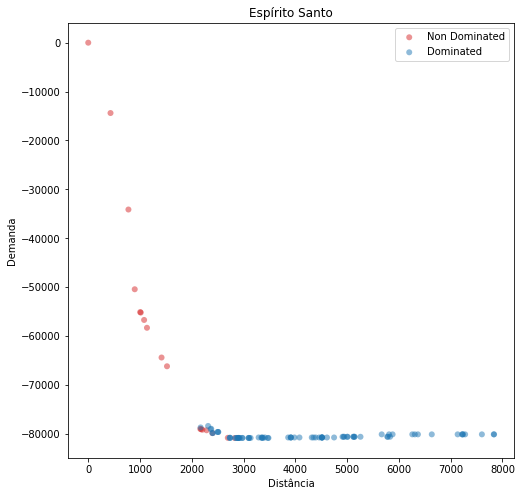

In [87]:
first_test = [[sol[0], -sol[1]] for sol in solutions_obj]

idx_non_dominated, idx_dominated = non_dominated(np.array(first_test))

x_plot = np.array([p[0] for p in first_test])
y_plot = np.array([p[1] for p in first_test])

fig, ax = plt.subplots(figsize=(8, 8))
plt.title('Espírito Santo')
plt.xlabel('Distância')
plt.ylabel('Demanda')

ax.scatter(x_plot[idx_non_dominated], y_plot[idx_non_dominated], c='tab:red', label='Non Dominated', alpha=0.5, edgecolors='none')
ax.scatter(x_plot[idx_dominated], y_plot[idx_dominated], c='tab:blue', label='Dominated', alpha=0.5, edgecolors='none')

ax.legend()
# ax.grid(True)

filename_fig = "ES-n78-m2-Q10138_with_depot_solver_0.png"
plt.savefig(filename_fig)

plt.show()

In [53]:
def save_result(outfilepath, solutions_obj):
    with open(outfilepath, 'w') as f:
        f.write("distancia, demanda\n")

        for sol in solutions_obj:
            f.write(f"{sol[0]}, {sol[1]}\n")

In [54]:
outfilepath = "ES-n78-m2-Q10138_with_depot.csv"
save_result(outfilepath, solutions_obj)

In [ ]:
# # Resolve o modelo        
# # model.optimize(max_seconds=7200)
# model.objective = objective(0, c, q, x, w)
# model.optimize(max_seconds=60)
# print("status: {} objective value : {} best possible: {}".format(model.status, model.objective_value, model.objective_bound))

In [ ]:
# model.gap

In [ ]:
# for i in range(5):
#     status = model.optimize(max_seconds=30)
    
#     if status == OptimizationStatus.OPTIMAL:
#         print("found optimal")
#     elif status == OptimizationStatus.FEASIBLE:
#         print("found feasible")
#     elif status == OptimizationStatus.NO_SOLUTION_FOUND:
#         print("run again")

---

## Testando resultados

In [ ]:
# dist percorrida
sum([(1 if x[i][j].x>0.5 else 0) * c[i,j] for i in V for j in V if i != j])

In [ ]:
# demanda total atendida
NUM_VEICULOS = sum(vehicles_depot)
print(f"demanda atendida: {sum(q[j]*w[j].x for j in N)} | limite demanda: {NUM_VEICULOS*Q} | total demanda: {sum(q)}")

In [ ]:
# # --- PLOTA O GRAFICO ---
# plt.figure(figsize=(10, 6))
# plt.scatter(coord_x[0:], coord_y[0:])
# for i in N:
#     plt.annotate(f"{i}", (coord_x[i], coord_y[i]))
# for i in D:
#     plt.plot(coord_x[i], coord_y[i], c = 'r', marker = 's')

# for i in V:
#     for j in V:
#         if x[i][j].x > 0:
#             plt.plot([coord_x[i], coord_x[j]], [coord_y[i], coord_y[j]], c='g', zorder=0)
    
# #escala dos eixos
# plt.yticks([i for i in range(1,80,20)]); 
# plt.xticks([i for i in range(1,80,20)]); 

In [ ]:
# para onde cada veículo vai
for k in D:
    print(f"{k} - ", end='')
    print([i for i, el in enumerate(u[k]) if el.x > 0])

In [ ]:
# caminho dos carros olhando arcos
for k in D:
    print(f"Depot: {k}")
    for i, el in enumerate(x[k]):
        if el.x > 0:
            visitados = [i]
            next_list = [j for j, el in enumerate(x[i]) if el.x > 0]
            while len(next_list) > 0:
                if len(next_list) > 1:
                    print(f"ERROR: {next_list}")
                next_el = next_list[0]
                visitados.append(next_el)
                next_list = [j for j, el in enumerate(x[next_el]) if el.x > 0]
            print(visitados)

In [ ]:
# caminho dos carros olhando demanda
for k in D:
    print(f"Depot: {k}")
    for i, el in enumerate(u[k]):
        if int(el.x) > 0:
            visitados = [(i, int(el.x))]
            next_list = [(j, int(el.x)) for j, el in enumerate(u[i]) if int(el.x) > 0]
            while len(next_list) > 0:
                if len(next_list) > 1:
                    print(f"ERROR: {next_list}")
                next_el, value = next_list[0]
                visitados.append((next_el, value))
                next_list = [(j, int(el.x)) for j, el in enumerate(u[next_el]) if int(el.x) > 0]
            print([(*el, q[el[0]]) for el in visitados])

In [ ]:
print("Cidades não atendidas")

# cidades não atendidas (olhando arestas)
print(f"aresta:  {([j for j in N if sum([x[i][j].x for i in V]) < 0.5])}")

# nao atendidos olhando demanda
print(f"demanda: {[j for j in N if (q[j] - (sum([u[i][j].x for i in V if i != j]) - sum([u[j][i].x for i in N if i != j]))) > 0.05]}")

# nao atendidos olhando w
print(f"w:       {[j for j in N if w[j].x < 0.5]}")

In [ ]:
# nao atendidos olhando w
for j in N:
    if w[j].x < 0.5:
        print(f"{j}-> demanda: {q[j]}")

In [ ]:
# nao atendidos olhando demanda
for j in N:
    enter = (sum([u[i][j].x for i in V if i != j]) - sum([u[j][i].x for i in N if i != j]))
    if (q[j] - enter) > 0.05:
        print(f"{j}-> enter: {enter}  need: {q[j]}")

In [ ]:
# nro de veiculos por depot

for k in D:
    print(f"depot {k}: {sum(x[k][i].x  for i in N)} vehicles")

In [ ]:
# cidades que tem mais de dois arcos ligadas a ela (depositos podem ter mais)
print([j for j in V if len([i for i in V if x[j][i].x > 0.5 or x[i][j].x > 0.5]) > 2])

In [ ]:
print(f"distancia media : {sum([c[el] for el in c])/len(c)}")
print(f"distancia maxima: {max([c[el] for el in c])}")
print(f"distancia minima: {min([c[el] for el in c])}")